<a href="https://colab.research.google.com/github/ayushwattal/LoanPredictionML/blob/main/Loan_Prediction_Exploration.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Importing libraries


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from pandas_profiling import ProfileReport
from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import BaggingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn import tree
from sklearn.metrics import classification_report,confusion_matrix
from collections import Counter
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import f1_score
from sklearn.metrics import r2_score
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import StratifiedKFold
import warnings

# Importing dataset

In [2]:
dataset = pd.read_csv('Loan.csv')

In [3]:
# from google.colab import drive
# drive.mount('/content/drive')

In [4]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 614 entries, 0 to 613
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Loan_ID            614 non-null    object 
 1   Gender             601 non-null    object 
 2   Married            611 non-null    object 
 3   Dependents         599 non-null    float64
 4   Education          614 non-null    object 
 5   Self_Employed      582 non-null    object 
 6   ApplicantIncome    614 non-null    int64  
 7   CoapplicantIncome  614 non-null    float64
 8   LoanAmount         592 non-null    float64
 9   Loan_Amount_Term   600 non-null    float64
 10  Credit_History     564 non-null    float64
 11  Property_Area      614 non-null    object 
 12  Loan_Status        614 non-null    object 
dtypes: float64(5), int64(1), object(7)
memory usage: 62.5+ KB


In [5]:
dataset.describe()

,Dependents,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History
count,599.000000,614.000000,614.000000,592.000000,600.00000,564.000000
mean,0.762938,5403.459283,1621.245603,146.412162,342.00000,0.842199
std,1.015216,6109.041673,2926.248477,85.587325,65.12041,0.364878
min,0.000000,150.000000,0.000000,9.000000,12.00000,0.000000
25%,0.000000,2877.500000,0.000000,100.000000,360.00000,1.000000
50%,0.000000,3812.500000,1188.500000,128.000000,360.00000,1.000000
75%,2.000000,5795.000000,2297.250000,168.000000,360.00000,1.000000
max,3.000000,81000.000000,41667.000000,700.000000,480.00000,1.000000


In [6]:
dataset.head()

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,LP001002,Male,No,0.0,Graduate,No,5849,0.0,NaN,360.0,1.0,Urban,Y
1,LP001003,Male,Yes,1.0,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N
2,LP001005,Male,Yes,0.0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y
3,LP001006,Male,Yes,0.0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,Y
4,LP001008,Male,No,0.0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,Y


# Data Exploration


## Entropy and Information Gain Calculation

In [7]:
from math import log
##################entropy related calculations###########################
def calculate_entropy(df, target_label, partition = None):  
    """
    df: data frame
    target_label: target col to calculate entropy 
    """
    col = df[target_label]
    if partition is not None: #partition by feature column
        col = df[df[partition[0]] == partition[1]][target_label]
        
    total = len(col)
    value,counts = np.unique(col , return_counts=True)  
    prob = counts / total
    entropy = 0
    for i in prob: 
        entropy -= i * log(i, 2)
    
    return entropy

def calculate_remainder(df, target_label, partition_by_class = None, class_condition = None):     
    rem = 0
    if partition_by_class is not None:
        rem_col = df[partition_by_class]
   
    total = len(rem_col)
    value,counts = np.unique(rem_col , return_counts=True)  
    entropy = []
    for i in value:
        entropy.append(calculate_entropy(df, target_label, partition = (partition_by_class, i)))
        
    for i,v in enumerate(entropy):
        rem += (counts[i]/total) * entropy[i]

    return rem


def information_gain_with_entropy(df, target_label, partition_by_class = None):
    """
    IG(d, D) = H(t, D) - rem(d, D)
    """
    return calculate_entropy(df, target_label) - calculate_remainder(df, target_label, partition_by_class = partition_by_class)

def information_gain_ratio_with_entropy(df, target_label, partition_by_class = None):
      return information_gain_with_entropy(df, target_label, partition_by_class) / calculate_entropy(df, partition_by_class)


In [8]:
print(f"entropy {'Loan_ID'}: {calculate_entropy(dataset, 'Loan_ID' ):.4}")
print(f"IG {'Loan_ID'}: {information_gain_with_entropy(dataset, 'Loan_Status', 'Loan_ID' ):.4}")

entropy Loan_ID: 9.262
IG Loan_ID: 0.8963


In [9]:
# Not taking load id as it will not impact loan 
dataset = dataset.drop(columns=["Loan_ID"])

The information gain for identification attributes will have highest information gain.
This can be seen for Loan_ID which has the highest information.
However, still we will remove this column in exploration part as this will not affect target feature. 

## Categorical Feature Analysis

In [10]:
#separating categorical and numerical features
categorical_features = [i for i in dataset.columns if dataset[i].nunique()<5]
categorical_features

['Gender',
 'Married',
 'Dependents',
 'Education',
 'Self_Employed',
 'Credit_History',
 'Property_Area',
 'Loan_Status']

## Categorical data quality report (Before Cleaning)



In [11]:
def get_categorical_abt_table (dataset_df, categorical_features): 
  cat_feature_arr = categorical_features
  cat_total_array = [''] *  len(cat_feature_arr)
  cat_non_nan_array  = [''] * len(cat_feature_arr)
  cat_miss_pct_array = [''] *  len(cat_feature_arr)
  cat_card_array = [''] * len(cat_feature_arr)
  cat_mode_array = [''] *len(cat_feature_arr)
  cat_mode_freq = [''] *len(cat_feature_arr)
  cat_mode_pct = [''] *len(cat_feature_arr)
  cat_2nd_mode_array = [''] *len(cat_feature_arr)
  cat_2nd_mode_freq = [''] *len(cat_feature_arr)
  cat_2nd_mode_pct = [''] *len(cat_feature_arr)

  for k, v in enumerate(categorical_features):
    cat_total_array[k] = dataset_df.shape[0] if len(dataset_df.shape)>0 else ''
    cat_non_nan_array[k] = dataset_df[v].count()
    cat_miss_pct_array[k] = 100 * ((dataset_df.shape[0] - dataset_df[v].count())/dataset_df.shape[0]) if len(dataset_df.shape)>0 else ''
    cat_card_array[k] = len(pd.unique(dataset_df[v])) 
  
    cat_mode_array[k]= Counter(dataset_df[v]).most_common()[0][0] if len(Counter(dataset_df[v]).most_common()) >0 else ''
    cat_mode_freq[k]= Counter(dataset_df[v]).most_common()[0][1] if len(Counter(dataset_df[v]).most_common()) >0 else ''
    cat_mode_pct[k] = 100* (Counter(dataset_df[v]).most_common()[0][1]/dataset_df.shape[0]) if len(Counter(dataset_df[v]).most_common()) >0 else ''
  
    cat_2nd_mode_array[k]= Counter(dataset_df[v]).most_common()[1][0] if len(Counter(dataset_df[v]).most_common())>1 else ''
    cat_2nd_mode_freq[k]= Counter(dataset_df[v]).most_common()[1][1] if len(Counter(dataset_df[v]).most_common())>1 else ''
    cat_2nd_mode_pct[k] = 100* (Counter(dataset_df[v]).most_common()[1][1]/dataset_df.shape[0]) if len(Counter(dataset_df[v]).most_common())>1 else ''

  cat_data = {'Categorical Feature':cat_feature_arr,\
          'total':cat_total_array,\
          'count':cat_non_nan_array,\
          'miss%':cat_miss_pct_array,\
          'card':cat_card_array,\
          'mode':cat_mode_array,\
          'mode freq':cat_mode_freq,\
          'mode pct':cat_mode_pct,\
          '2nd mode':cat_2nd_mode_array,\
          '2nd mode freq':cat_2nd_mode_freq,\
          '2nd mode pct':cat_2nd_mode_pct
              
        }
  cat_data = pd.DataFrame(cat_data)     
  return cat_data

In [12]:
get_categorical_abt_table(dataset, categorical_features)


,Categorical Feature,total,count,miss%,card,mode,mode freq,mode pct,2nd mode,2nd mode freq,2nd mode pct
0,Gender,614,601,2.117264,3,Male,489,79.641694,Female,112,18.241042
1,Married,614,611,0.488599,3,Yes,398,64.820847,No,213,34.690554
2,Dependents,614,599,2.442997,5,0,345,56.188925,1,102,16.612378
3,Education,614,614,0.000000,2,Graduate,480,78.175896,Not Graduate,134,21.824104
4,Self_Employed,614,582,5.211726,3,No,500,81.433225,Yes,82,13.355049
5,Credit_History,614,564,8.143322,3,1,475,77.361564,0,89,14.495114
6,Property_Area,614,614,0.000000,3,Semiurban,233,37.947883,Urban,202,32.899023
7,Loan_Status,614,614,0.000000,2,Y,422,68.729642,N,192,31.270358


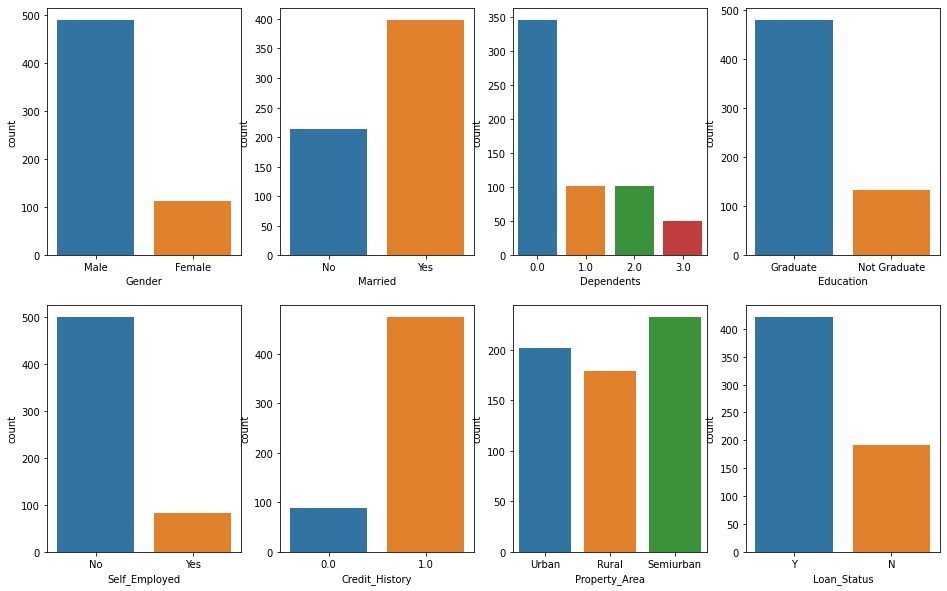

In [13]:
fig,ax = plt.subplots(2,4,figsize=(16,10))
sns.countplot(x='Gender',data=dataset, ax=ax[0][0])
sns.countplot(x='Married',data=dataset, ax=ax[0][1])
sns.countplot(x='Dependents',data=dataset, ax=ax[0][2])
sns.countplot(x='Education',data=dataset, ax=ax[0][3])
sns.countplot(x='Self_Employed',data=dataset, ax=ax[1][0])
sns.countplot(x='Credit_History',data=dataset, ax=ax[1][1])
sns.countplot(x='Property_Area',data=dataset, ax=ax[1][2])
sns.countplot(x='Loan_Status',data=dataset, ax=ax[1][3])
plt.show()

From above countplot,
There are more number of male applicants than female.
Most applicants are married.
Loan applicants with 0 dependents are more. Applicants with 3 or more dependents are very less.
Most applicants are graduate.
The dataset has most applicants who are not self employed.
Most applicants had good credit history.
There are more number of applicant living in semiurban area than urban and rural.



## Continuous Feature Analysis

## Continuous data quality report (before cleaning)


In [14]:
continuous_features = [i for i in dataset.columns if dataset[i].nunique()>=5 and i!='Loan_ID']
continuous_features

['ApplicantIncome', 'CoapplicantIncome', 'LoanAmount', 'Loan_Amount_Term']

In [15]:
def get_countinous_abt_table(dataset_df, continuous_features):
  feature_arr = continuous_features
  total_array = [''] *  len(continuous_features)
  non_nan_array  = [''] *  len(continuous_features)
  miss_pct_array = [''] *  len(continuous_features)
  card_array = [''] *  len(continuous_features)
  min_array  = [''] *  len(continuous_features)
  max_array = [''] *  len(continuous_features)
  qrt_1st_array = [''] *  len(continuous_features)
  mean_array = [''] *  len(continuous_features)
  median_array  = [''] *  len(continuous_features)
  qrt_3rd_array  = [''] *  len(continuous_features)
  std_array = [''] *  len(continuous_features)

  for k, v in enumerate(continuous_features):
      total_array[k] = dataset_df.shape[0]
      non_nan_array[k] = dataset_df[v].count()
      miss_pct_array[k] = 100 *  ((dataset_df.shape[0] - dataset_df[v].count())/dataset_df.shape[0])
      card_array[k] = len(pd.unique(dataset_df[v]))
      min_array[k] = min(dataset_df[v])
      max_array[k] = max(dataset_df[v])
      std_array[k] = np.std(dataset_df[v])
      mean_array[k] = np.mean(dataset_df[v])
      median_array[k] = np.nanmedian(dataset_df[v])
      qrt_1st_array[k] = np.nanquantile(dataset_df[v], .25)
      qrt_3rd_array[k] = np.nanquantile(dataset_df[v], .75)
      

  continous_data = {'Continous Feature':feature_arr,\
          'total':total_array,\
          'count':non_nan_array,\
          'miss%':miss_pct_array,\
          'card':card_array,\
          'min':min_array,\
          '1st qrt':qrt_1st_array,\
          'mean':mean_array,\
          'median':median_array,\
          '3rd qrt':qrt_3rd_array,\
          'max':max_array,\
          'std':std_array,\
        }
  continous_data = pd.DataFrame(continous_data)     
  return continous_data

In [16]:
get_countinous_abt_table(dataset, continuous_features)

,Continous Feature,total,count,miss%,card,min,1st qrt,mean,median,3rd qrt,max,std
0,ApplicantIncome,614,614,0.000000,505,150.0,2877.5,5403.459283,3812.5,5795.00,81000.0,6104.064857
1,CoapplicantIncome,614,614,0.000000,287,0.0,0.0,1621.245603,1188.5,2297.25,41667.0,2923.864567
2,LoanAmount,614,592,3.583062,204,NaN,100.0,146.412162,128.0,168.00,NaN,85.515008
3,Loan_Amount_Term,614,600,2.280130,11,12.0,360.0,342.000000,360.0,360.00,480.0,65.066120


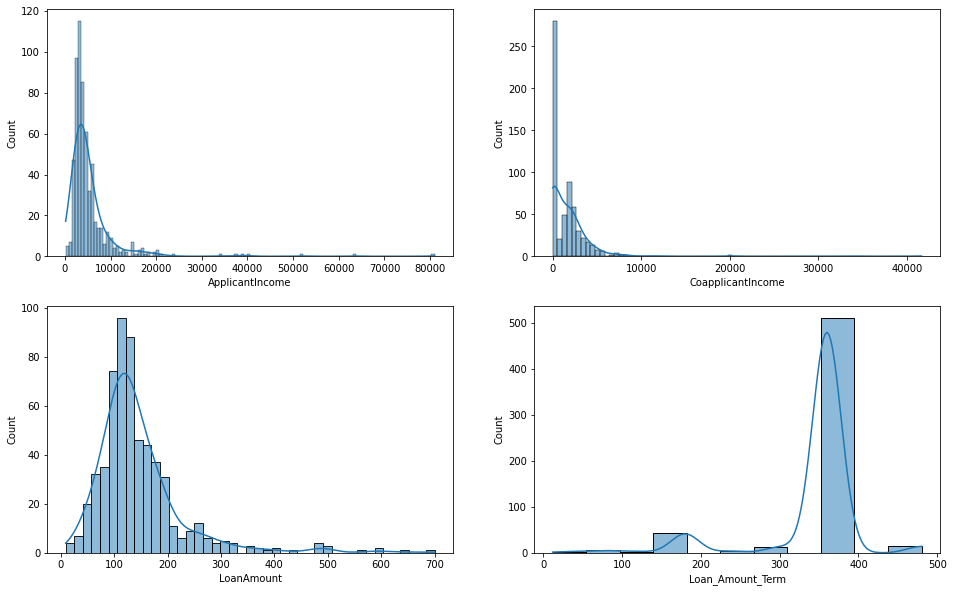

In [17]:
fig, ax = plt.subplots(2,2,figsize=(16,10))
sns.histplot(dataset['ApplicantIncome'],kde=True, ax=ax[0, 0])
sns.histplot(dataset['CoapplicantIncome'],kde=True, ax=ax[0, 1])
sns.histplot(dataset['LoanAmount'],kde=True, ax=ax[1, 0])
sns.histplot(dataset['Loan_Amount_Term'],kde=True, ax=ax[1, 1])
plt.show()

From above histplot,
for applicant income, the range is 10 to 80000.
The data is right skewed. Most applicant has income in the range of 10 to 10000
for coapplicant income, income is in range 10 to 40000.
The data is right skewed. Most coapplicant has income in the range 10 to 10000
for loan amount feature , loan amount range is approximately 10 to 700.
The distribution is right skewed. Most values lie in the range of 80 to 180.

# Data Cleaning

## Handling null values

In [18]:
dataset.head(5)

,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,Male,No,0.0,Graduate,No,5849,0.0,NaN,360.0,1.0,Urban,Y
1,Male,Yes,1.0,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N
2,Male,Yes,0.0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y
3,Male,Yes,0.0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,Y
4,Male,No,0.0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,Y


In [19]:
# checking null values in dataset
dataset.isnull().sum() 

Gender               13
Married               3
Dependents           15
Education             0
Self_Employed        32
ApplicantIncome       0
CoapplicantIncome     0
LoanAmount           22
Loan_Amount_Term     14
Credit_History       50
Property_Area         0
Loan_Status           0
dtype: int64

In [20]:
#filling the null values of continuous features with the its mean
dataset['ApplicantIncome'] = dataset['ApplicantIncome'].fillna(dataset['ApplicantIncome'].mean())
dataset['CoapplicantIncome'] = dataset['CoapplicantIncome'].fillna(dataset['CoapplicantIncome'].mean())
dataset['LoanAmount'] = dataset['LoanAmount'].fillna(dataset['LoanAmount'].mean())
dataset['Loan_Amount_Term'] = dataset['Loan_Amount_Term'].fillna(dataset['Loan_Amount_Term'].mean())


In [21]:
#filling the null values of categorical features with the its mode
dataset ['Gender'] = dataset ['Gender'].fillna(dataset['Gender'].mode()[0])
dataset ['Married'] = dataset ['Married'].fillna(dataset['Married'].mode()[0])
dataset ['Dependents'] = dataset ['Dependents'].fillna(dataset['Dependents'].mode()[0])
dataset ['Education'] = dataset ['Education'].fillna(dataset['Education'].mode()[0])
dataset ['Self_Employed'] = dataset ['Self_Employed'].fillna(dataset['Self_Employed'].mode()[0])
dataset['Credit_History'] = dataset['Credit_History'].fillna(dataset['Credit_History'].mode()[0])
dataset ['Property_Area'] = dataset ['Property_Area'].fillna(dataset['Property_Area'].mode()[0])
dataset ['Loan_Status'] = dataset ['Loan_Status'].fillna(dataset['Loan_Status'].mode()[0])

In [22]:
#There are no null values in the dataset
dataset.isnull().sum()

Gender               0
Married              0
Dependents           0
Education            0
Self_Employed        0
ApplicantIncome      0
CoapplicantIncome    0
LoanAmount           0
Loan_Amount_Term     0
Credit_History       0
Property_Area        0
Loan_Status          0
dtype: int64

In [23]:
#Top 5 rows of cleaned dataset
dataset.head()

,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,Male,No,0.0,Graduate,No,5849,0.0,146.412162,360.0,1.0,Urban,Y
1,Male,Yes,1.0,Graduate,No,4583,1508.0,128.000000,360.0,1.0,Rural,N
2,Male,Yes,0.0,Graduate,Yes,3000,0.0,66.000000,360.0,1.0,Urban,Y
3,Male,Yes,0.0,Not Graduate,No,2583,2358.0,120.000000,360.0,1.0,Urban,Y
4,Male,No,0.0,Graduate,No,6000,0.0,141.000000,360.0,1.0,Urban,Y


## Categorical data quality report (After cleaning)

In [24]:
get_categorical_abt_table(dataset, categorical_features)

,Categorical Feature,total,count,miss%,card,mode,mode freq,mode pct,2nd mode,2nd mode freq,2nd mode pct
0,Gender,614,614,0.0,2,Male,502,81.758958,Female,112,18.241042
1,Married,614,614,0.0,2,Yes,401,65.309446,No,213,34.690554
2,Dependents,614,614,0.0,4,0,360,58.631922,1,102,16.612378
3,Education,614,614,0.0,2,Graduate,480,78.175896,Not Graduate,134,21.824104
4,Self_Employed,614,614,0.0,2,No,532,86.644951,Yes,82,13.355049
5,Credit_History,614,614,0.0,2,1,525,85.504886,0,89,14.495114
6,Property_Area,614,614,0.0,3,Semiurban,233,37.947883,Urban,202,32.899023
7,Loan_Status,614,614,0.0,2,Y,422,68.729642,N,192,31.270358


## Continous data quality report (After Cleaning)

In [25]:
get_countinous_abt_table(dataset, continuous_features)

,Continous Feature,total,count,miss%,card,min,1st qrt,mean,median,3rd qrt,max,std
0,ApplicantIncome,614,614,0.0,505,150.0,2877.50,5403.459283,3812.5,5795.00,81000.0,6104.064857
1,CoapplicantIncome,614,614,0.0,287,0.0,0.00,1621.245603,1188.5,2297.25,41667.0,2923.864567
2,LoanAmount,614,614,0.0,204,9.0,100.25,146.412162,129.0,164.75,700.0,83.969005
3,Loan_Amount_Term,614,614,0.0,11,12.0,360.00,342.000000,360.0,360.00,480.0,64.320047


No missing values can be seen after data cleaning.

# Encoding

## Encoding features with binary values

In [26]:
# checking data type of columns before encoding
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 614 entries, 0 to 613
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Gender             614 non-null    object 
 1   Married            614 non-null    object 
 2   Dependents         614 non-null    float64
 3   Education          614 non-null    object 
 4   Self_Employed      614 non-null    object 
 5   ApplicantIncome    614 non-null    int64  
 6   CoapplicantIncome  614 non-null    float64
 7   LoanAmount         614 non-null    float64
 8   Loan_Amount_Term   614 non-null    float64
 9   Credit_History     614 non-null    float64
 10  Property_Area      614 non-null    object 
 11  Loan_Status        614 non-null    object 
dtypes: float64(5), int64(1), object(6)
memory usage: 57.7+ KB


In [27]:
le = LabelEncoder()
dataset['Gender'] = le.fit_transform(dataset['Gender'].astype(str))
dataset['Married'] = le.fit_transform(dataset['Married'].astype(str))
dataset['Education'] = le.fit_transform(dataset['Education'].astype(str))
dataset['Self_Employed'] = le.fit_transform(dataset['Self_Employed'].astype(str))
dataset['Property_Area'] = le.fit_transform(dataset['Property_Area'].astype(str))
dataset['Loan_Status'] = le.fit_transform(dataset['Loan_Status'].astype(str))

In [28]:
# checking if encoding convert the datatypy of features
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 614 entries, 0 to 613
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Gender             614 non-null    int64  
 1   Married            614 non-null    int64  
 2   Dependents         614 non-null    float64
 3   Education          614 non-null    int64  
 4   Self_Employed      614 non-null    int64  
 5   ApplicantIncome    614 non-null    int64  
 6   CoapplicantIncome  614 non-null    float64
 7   LoanAmount         614 non-null    float64
 8   Loan_Amount_Term   614 non-null    float64
 9   Credit_History     614 non-null    float64
 10  Property_Area      614 non-null    int64  
 11  Loan_Status        614 non-null    int64  
dtypes: float64(5), int64(7)
memory usage: 57.7 KB


# Correlation after data cleaning

In [29]:
corr = dataset.corr(method='pearson')
corr

,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
Gender,1.000000,0.364569,0.172914,0.045364,-0.000525,0.058809,0.082912,0.107930,-0.073567,0.009170,-0.025752,0.017987
Married,0.364569,1.000000,0.334216,0.012304,0.004489,0.051708,0.075948,0.147141,-0.100863,0.010938,0.004257,0.091478
Dependents,0.172914,0.334216,1.000000,0.055752,0.056798,0.118202,0.030430,0.163106,-0.101054,-0.040160,-0.000244,0.010118
Education,0.045364,0.012304,0.055752,1.000000,-0.010383,-0.140760,-0.062290,-0.166998,-0.077242,-0.073658,-0.065243,-0.085884
Self_Employed,-0.000525,0.004489,0.056798,-0.010383,1.000000,0.127180,-0.016100,0.115260,-0.033943,-0.001550,-0.030860,-0.003700
ApplicantIncome,0.058809,0.051708,0.118202,-0.140760,0.127180,1.000000,-0.116605,0.565620,-0.045242,-0.018615,-0.009500,-0.004710
CoapplicantIncome,0.082912,0.075948,0.030430,-0.062290,-0.016100,-0.116605,1.000000,0.187828,-0.059675,0.011134,0.010522,-0.059187
LoanAmount,0.107930,0.147141,0.163106,-0.166998,0.115260,0.565620,0.187828,1.000000,0.038801,-0.001431,-0.044776,-0.036416
Loan_Amount_Term,-0.073567,-0.100863,-0.101054,-0.077242,-0.033943,-0.045242,-0.059675,0.038801,1.000000,0.000432,-0.077620,-0.020974
Credit_History,0.009170,0.010938,-0.040160,-0.073658,-0.001550,-0.018615,0.011134,-0.001431,0.000432,1.000000,0.001963,0.540556


# Correlation heat map

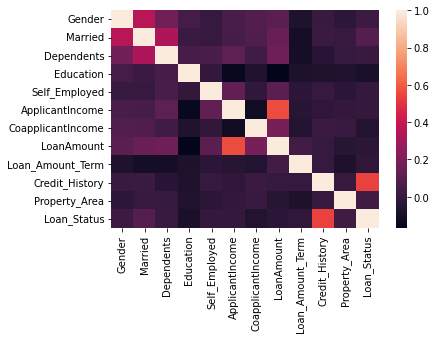

In [30]:
sns.heatmap(corr, xticklabels = corr.columns.values, yticklabels=corr.columns.values)

# Dividing dataset into X as descriptive features and y as target feature

In [31]:
X = dataset.iloc[:, :-1].values # Gender to Property_Area 
y = dataset.iloc[:, -1].values # Loan_Status 

In [32]:
# Using one hot encoding for Property_Area and Dependents features

ct = ColumnTransformer(transformers=[('encoder', OneHotEncoder(), [2, 10])], remainder='passthrough')
X = np.array(ct.fit_transform(X))

# Splitting the dataset into the Training set and Test set

In [33]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state = 0)

# Feature scaling

In [34]:
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)


# Modeling

In [35]:
final_evaluation = {
    "Model":[],
    "accuracy_score":[],
    "auc":[],
    "F1 score":[]
}

In [36]:
# same random_state throughout process including K-fold
_random_state = 4

## Decision Tree Classifier

### Training Decision Tree Classifier

In [37]:
# Training , Testing and Predcitng values using DecisionTree Classifier

decision_tree = DecisionTreeClassifier(random_state=_random_state)
decision_tree.fit(X_train, y_train)
y_pred_decision_tree = decision_tree.predict(X_test)

#Calculating accuracy Score for Model
print(f'Accuracy Score of Decision Tree Classifier  is {accuracy_score(y_test, y_pred_decision_tree)}')

final_evaluation["Model"].append("DecisionTreeClassifier")  

Accuracy Score of Decision Tree Classifier  is 0.6910569105691057


### Tuning Decision Tree Classifier

In [38]:
criterion=["gini", "entropy"]
splitter = ["best", "random"]
max_features = ["auto", "sqrt", "log2"]
grid = dict(criterion=criterion, splitter=splitter, max_features=max_features)
model = DecisionTreeClassifier(random_state=_random_state)
grid = GridSearchCV(estimator=model, param_grid=grid, scoring='accuracy')
grid_result = grid.fit(X_train, y_train)
print("Best score: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

Best score: 0.720985 using {'criterion': 'gini', 'max_features': 'auto', 'splitter': 'best'}


In [39]:
tuned_decision_tree = DecisionTreeClassifier(random_state=_random_state, criterion='gini', max_features='auto', splitter='best')
tuned_decision_tree.fit(X_train, y_train)
y_pred_tuned_decision_tree = tuned_decision_tree.predict(X_test)

#Calculating accuracy score between test value and predictive value for target
accuracy_tuned_decision_tree = accuracy_score(y_test, y_pred_tuned_decision_tree)

#Printing the accuracy score for Decision Tree Classifier model
print(f'Accuracy Score of Tuned Decision Tree Classifier model is {accuracy_tuned_decision_tree}')
final_evaluation["Model"].append("Tuned DecisionTreeClassifier") 


Accuracy Score of Tuned Decision Tree Classifier model is 0.7235772357723578


### Stratefied K Fold Validation For Decision Tree

In [40]:
warnings.filterwarnings("ignore")
accuracy_decision_tree = []
accuracy_tuned_decision_tree = []
cm_decision_tree = []
cm_tunned_decision_tree = []
f1_score_decision_tree = []
f1_score_tunned_decision_tree = []
roc = []
roc_tuned = []

skf = StratifiedKFold(n_splits = 5,random_state = _random_state, shuffle = True)

skf.get_n_splits(X,y)
for train_index, test_index in skf.split(X,y):
  # print("Train : ",train_index, "Validation : ",test_index)
  X1_train, X1_test = X[train_index],X[test_index]
  y1_train, y1_test = y[train_index],y[test_index]

  decision_tree.fit(X1_train,y1_train)
  decision_tree_predictions = decision_tree.predict(X1_test)
  score = accuracy_score(decision_tree_predictions,y1_test)
  accuracy_decision_tree.append(score)
  cm_decision_tree = confusion_matrix(y1_test, decision_tree_predictions)
  f1 = f1_score(y1_test, decision_tree_predictions)
  f1_score_decision_tree.append(f1)
  roc = roc_curve(y1_test, decision_tree_predictions)

  tuned_decision_tree.fit(X1_train,y1_train)
  tuned_decision_tree_predictions = tuned_decision_tree.predict(X1_test)
  score = accuracy_score(tuned_decision_tree_predictions,y1_test)
  accuracy_tuned_decision_tree.append(score)
  cm_tunned_decision_tree = confusion_matrix(y1_test, tuned_decision_tree_predictions)
  f1_score_tunned = f1_score(y1_test, tuned_decision_tree_predictions)
  f1_score_tunned_decision_tree.append(f1_score_tunned)
  roc_tuned = roc_curve(y1_test, tuned_decision_tree_predictions)

accuracy_score_decision_tree = np.array(accuracy_decision_tree).mean()
accuracy_score_tuned_decision_tree = np.array(accuracy_tuned_decision_tree).mean()
f1_score_decision_tree = np.array(f1_score_decision_tree).mean()
f1_score_tunned_decision_tree = np.array(f1_score_tunned_decision_tree).mean()

print(f'Accuracy Score of Decision Tree Classifier is {accuracy_score_decision_tree}')
print(f'Accuracy Score of Tuned Decision Tree Classifier is {accuracy_score_tuned_decision_tree}')

Accuracy Score of Decision Tree Classifier is 0.6938024790083965
Accuracy Score of Tuned Decision Tree Classifier is 0.7246701319472211


### Evaluation

#### Confusion Matrix

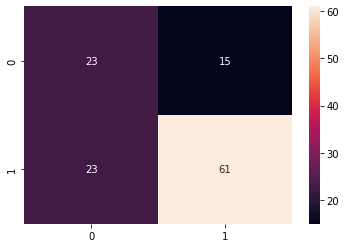

In [41]:
sns.heatmap(cm_decision_tree, annot=True, fmt="d")

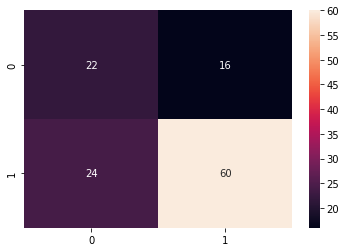

In [42]:
sns.heatmap(cm_tunned_decision_tree, annot=True, fmt="d")

#### Overall Accuracy

In [43]:
print(f'Accuracy Score of Decision Tree Classifier is {accuracy_score_decision_tree}')
final_evaluation["accuracy_score"].append(accuracy_score_decision_tree) 
print(f'Accuracy Score of Tuned Decision Tree Classifier is {accuracy_score_tuned_decision_tree}')
final_evaluation["accuracy_score"].append(accuracy_score_tuned_decision_tree) 

Accuracy Score of Decision Tree Classifier is 0.6938024790083965
Accuracy Score of Tuned Decision Tree Classifier is 0.7246701319472211


#### F1-Score

In [44]:
print(f"F1 score of decision tree: {f1_score_decision_tree}")
final_evaluation["F1 score"].append(f1_score_decision_tree) 


F1 score of decision tree: 0.7749787337269687


In [45]:
print(f"F1 score of tunned decision tree: {f1_score_tunned_decision_tree}")
final_evaluation["F1 score"].append(f1_score_tunned_decision_tree) 

F1 score of tunned decision tree: 0.798954308401741


#### ROC Curve and AUC

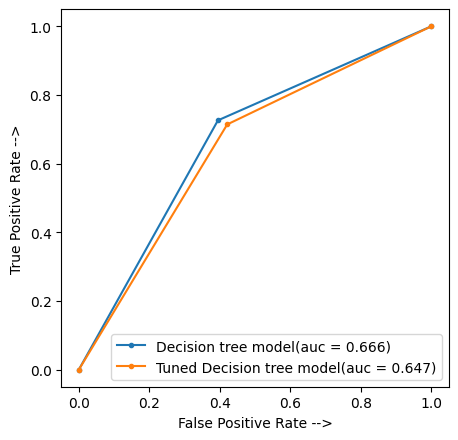

In [46]:
decision_tree_fpr, decision_tree_tpr, threshold = roc
auc_decision_tree = auc(decision_tree_fpr, decision_tree_tpr)

tuned_decision_tree_fpr, tuned_decision_tree_tpr, threshold = roc_tuned
tuned_auc_decision_tree = auc(tuned_decision_tree_fpr, tuned_decision_tree_tpr)

plt.figure(figsize=(5, 5), dpi=100)
plt.plot(decision_tree_fpr, decision_tree_tpr, linestyle='-', marker='.', label='Decision tree model(auc = %0.3f)' % auc_decision_tree)
final_evaluation["auc"].append(auc_decision_tree) 
plt.plot(tuned_decision_tree_fpr, tuned_decision_tree_tpr, marker='.', label='Tuned Decision tree model(auc = %0.3f)' % tuned_auc_decision_tree)
final_evaluation["auc"].append(tuned_auc_decision_tree) 


plt.xlabel('False Positive Rate -->')
plt.ylabel('True Positive Rate -->')

plt.legend()

plt.show()

In [47]:
!pip install scikit-plot

#### Learning Curve

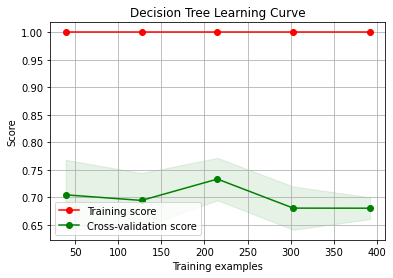

In [48]:
import scikitplot as skplt
skplt.estimators.plot_learning_curve(decision_tree, X_train, y_train, title="Decision Tree Learning Curve", 
                                     scoring = 'accuracy', cv=skf, random_state=_random_state)
plt.show()

## Logistic Regression

### Training Logistic Regression

In [49]:
logistic_classifier = LogisticRegression(random_state=_random_state)
logistic_classifier.fit(X_train, y_train)

LogisticRegression(random_state=4)

In [50]:
y_pred_logistic = logistic_classifier.predict(X_test)
print(f'Accuracy Score of Logistic Regression model is {accuracy_score(y_test, y_pred_logistic)}')
final_evaluation["Model"].append("LogisticRegression")  

Accuracy Score of Logistic Regression model is 0.8373983739837398


### Tuning Logistic Regression 

In [51]:
solvers = ['newton-cg', 'lbfgs', 'liblinear']
penalty = ['l2']
c_values = [100, 10, 1.0, 0.1, 0.01]
# c_values = [0.001, 0.01, 0.1, 1, 10]
grid = dict(solver=solvers,penalty=penalty,C=c_values)
model = LogisticRegression(random_state=_random_state)
grid = GridSearchCV(estimator=model, param_grid=grid, scoring='accuracy')
grid_result = grid.fit(X_train, y_train)
print("Best score: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

Best score: 0.804432 using {'C': 100, 'penalty': 'l2', 'solver': 'newton-cg'}


In [52]:
tuned_logistic_model = LogisticRegression(random_state=_random_state, C=1, penalty='l2', solver='newton-cg')
tuned_logistic_model
tuned_logistic_model.fit(X_train, y_train)
y_pred_tuned_logistic = tuned_logistic_model.predict(X_test)

#Calculating accuracy score between test value and predictive value for target
accuracy_tuned_logistic_model = accuracy_score(y_test, y_pred_tuned_logistic)

#Printing the accuracy score for logistic regression model
print(f'Accuracy Score of Tuned Logistic Regression model is {accuracy_tuned_logistic_model}')
final_evaluation["Model"].append("Tuned LogisticRegression") 

Accuracy Score of Tuned Logistic Regression model is 0.8373983739837398


### Stratefied K Fold Validation For Logistic Regression

In [53]:
warnings.filterwarnings("ignore")
accuracy_logistic = []
accuracy_tuned_logistic = []
cm_logistic = []
cm_tunned_logistic = []
f1_score_logistic = []
f1_score_tunned_logistic = []
roc = []
roc_tuned = []

skf = StratifiedKFold(n_splits = 5,random_state =_random_state, shuffle = True)

skf.get_n_splits(X,y)
for train_index, test_index in skf.split(X,y):
  # print("Train : ",train_index, "Validation : ",test_index)
  X1_train, X1_test = X[train_index],X[test_index]
  y1_train, y1_test = y[train_index],y[test_index]

  logistic_classifier.fit(X1_train,y1_train)
  logistic_predictions = logistic_classifier.predict(X1_test)
  score = accuracy_score(logistic_predictions,y1_test)
  accuracy_logistic.append(score)
  cm_logistic = confusion_matrix(y1_test, logistic_predictions)
  f1 = f1_score(y1_test, logistic_predictions)
  f1_score_logistic.append(f1)
  roc = roc_curve(y1_test, logistic_predictions)

  tuned_logistic_model.fit(X1_train,y1_train)
  tuned_logistic_predictions = tuned_logistic_model.predict(X1_test)
  score = accuracy_score(tuned_logistic_predictions,y1_test)
  accuracy_tuned_logistic.append(score)
  cm_tunned_logistic = confusion_matrix(y1_test, tuned_logistic_predictions)
  f1 = f1_score(y1_test, tuned_logistic_predictions)
  f1_score_tunned_logistic.append(f1)
  roc_tuned = roc_curve(y1_test, tuned_logistic_predictions)

accuracy_score_logistic = np.array(accuracy_logistic).mean()
accuracy_score_tuned_logistic = np.array(accuracy_tuned_logistic).mean()
f1_score_logistic = np.array(f1_score_logistic).mean()
f1_score_tunned_logistic = np.array(f1_score_tunned_logistic).mean()

print(f'Accuracy Score of Logistic Regression is {accuracy_score_logistic}')
print(f'Accuracy Score of Tuned Logistic Regression is {accuracy_score_tuned_logistic}')

Accuracy Score of Logistic Regression is 0.7964814074370252
Accuracy Score of Tuned Logistic Regression is 0.8111155537784887


### Evaluation

#### Confusion Matrix

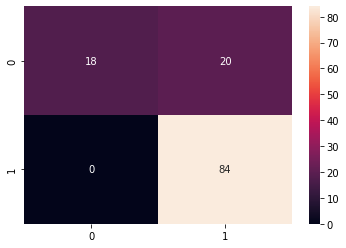

In [54]:
sns.heatmap(cm_logistic, annot=True, fmt="d")

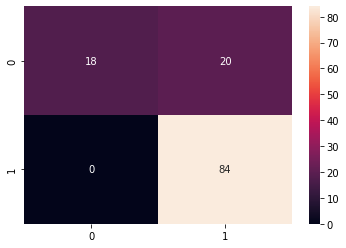

In [55]:
sns.heatmap(cm_tunned_logistic, annot=True, fmt="d")

#### Overall Accuracy

In [56]:
print(f'Accuracy Score of Logistic Regression is {accuracy_score_logistic}')
final_evaluation["accuracy_score"].append(accuracy_score_logistic) 
print(f'Accuracy Score of Tuned Logistic Regression is {accuracy_score_tuned_logistic}')
final_evaluation['accuracy_score'].append(accuracy_score_tuned_logistic)

Accuracy Score of Logistic Regression is 0.7964814074370252
Accuracy Score of Tuned Logistic Regression is 0.8111155537784887


#### F1-Score

In [57]:
print(f'F1-Score of Logistic Regression is {f1_score_logistic}')
final_evaluation["F1 score"].append(f1_score_logistic) 

F1-Score of Logistic Regression is 0.8663952491115952


In [58]:
print(f'F1-Score of Tuned Logistic Regression is {f1_score_tunned_logistic}')
final_evaluation["F1 score"].append(f1_score_tunned_logistic) 

F1-Score of Tuned Logistic Regression is 0.8773082216397263


#### ROC curve and AUC

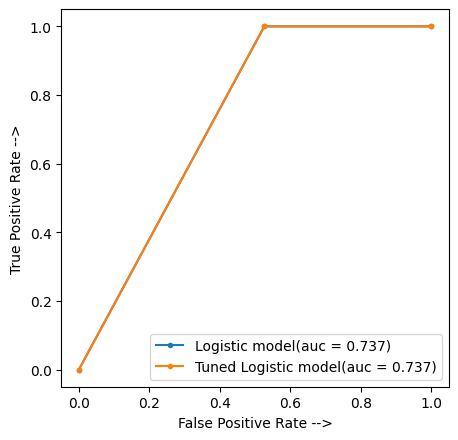

In [59]:
logistic_fpr, logistic_tpr, threshold = roc
auc_logistic = auc(logistic_fpr, logistic_tpr)

tuned_logistic_fpr, tuned_logistic_tpr, threshold = roc_tuned
tuned_auc_logistic = auc(tuned_logistic_fpr, tuned_logistic_tpr)

plt.figure(figsize=(5, 5), dpi=100)
plt.plot(logistic_fpr, logistic_tpr, linestyle='-', marker='.', label='Logistic model(auc = %0.3f)' % auc_logistic)
plt.plot(tuned_logistic_fpr, tuned_logistic_tpr, marker='.', label='Tuned Logistic model(auc = %0.3f)' % tuned_auc_logistic)
final_evaluation["auc"].append(auc_logistic) 
final_evaluation["auc"].append(tuned_auc_logistic) 

plt.xlabel('False Positive Rate -->')
plt.ylabel('True Positive Rate -->')

plt.legend()

plt.show()

#### Learning Curve

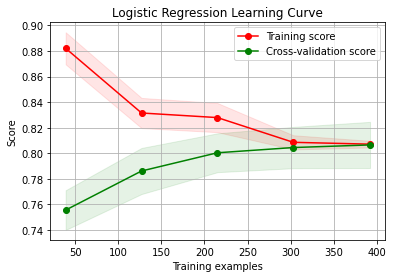

In [60]:
import scikitplot as skplt
skplt.estimators.plot_learning_curve(logistic_classifier, X_train, y_train, title="Logistic Regression Learning Curve",
                                     scoring = 'accuracy', cv=skf, random_state=_random_state)
plt.show()

Our main aim in model is to reduce the bias and variance. Thus, we need to find the variance and bias trade off. From the above learning curve we can see that model performance is increased as the training size increased. Also, the red line (training line) and green line (cross validation) line are meeting at some point which shows us the best performance of model than other models.

## AdaBoost Classifier




### Training AdaBoost Classifier

In [61]:
# Training , Testing and Predcitng values using AdaBoost Classifier
adaBoost_clf = AdaBoostClassifier(DecisionTreeClassifier(max_depth=2), n_estimators=500, algorithm="SAMME.R", random_state =_random_state)
adaBoost_clf.fit(X_train, y_train)
y_pred_ada = adaBoost_clf.predict(X_test)
#Calculating accuracy score between test value and predictive value for target
accuracy_ada = accuracy_score(y_test, y_pred_ada)
print(f'Accuracy Score of AdaBoost Classifier is {accuracy_ada}')
final_evaluation["Model"].append("AdaBoostClassifier")  

Accuracy Score of AdaBoost Classifier is 0.8048780487804879


### Tuning AdaBoost Classifier

In [62]:
model = AdaBoostClassifier(random_state =_random_state)
n_estimators = [10, 50, 100, 500, 1000, 5000]
algorithm = ['SAMME', 'SAMME.R']
learning_rate = [0.0001, 0.001, 0.01, 0.1, 1]
# define grid search
grid = dict(n_estimators = n_estimators, algorithm = algorithm, learning_rate = learning_rate )
grid_search = GridSearchCV(estimator=model, param_grid=grid, n_jobs=-1, scoring='accuracy',error_score=0)
grid_result = grid_search.fit(X_train, y_train)
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

Best: 0.804432 using {'algorithm': 'SAMME', 'learning_rate': 0.0001, 'n_estimators': 10}


In [63]:
adaBoost_clf_tuned = AdaBoostClassifier(random_state =_random_state, n_estimators=10, learning_rate = 0.0001, algorithm = 'SAMME')
adaBoost_clf_tuned
adaBoost_clf_tuned.fit(X_train, y_train)
y_pred_tuned_ada = adaBoost_clf_tuned.predict(X_test)

#Calculating accuracy score between test value and predictive value for target
accuracy_tuned_adaBoost_model = accuracy_score(y_test, y_pred_tuned_ada)

#Printing the accuracy score for ada boost model
print(f'Accuracy Score of Tuned AdaBoost model is {accuracy_tuned_adaBoost_model}')
final_evaluation["Model"].append("Tuned AdaBoost") 

Accuracy Score of Tuned AdaBoost model is 0.8292682926829268


### Stratefied K Fold Validation For AdaBoost Classifier

In [64]:
adaBoost_clf_tuned = AdaBoostClassifier(random_state =_random_state, n_estimators=10, learning_rate = 0.0001, algorithm = 'SAMME')

warnings.filterwarnings("ignore")
accuracy_adaboost = []
accuracy_tuned_ada = []
cm_adaboost = []
cm_tunned_adaboost = []
f1_score_adaboost = []
f1_score_tunned_adaboost = []
roc = []
roc_tuned = []

skf = StratifiedKFold(n_splits = 5,random_state =_random_state, shuffle = True)

skf.get_n_splits(X,y)
for train_index, test_index in skf.split(X,y):
  # print("Train : ",train_index, "Validation : ",test_index)
  X1_train, X1_test = X[train_index],X[test_index]
  y1_train, y1_test = y[train_index],y[test_index]

  adaBoost_clf.fit(X1_train,y1_train)
  ada_predictions = adaBoost_clf.predict(X1_test)
  score = accuracy_score(ada_predictions,y1_test)
  accuracy_adaboost.append(score)
  cm_adaboost = confusion_matrix(y1_test, ada_predictions)
  f1 = f1_score(y1_test, ada_predictions)
  f1_score_adaboost.append(f1)
  roc = roc_curve(y1_test, ada_predictions)

  adaBoost_clf_tuned.fit(X1_train,y1_train)
  tuned_ada_predictions = adaBoost_clf_tuned.predict(X1_test)
  score = accuracy_score(tuned_ada_predictions,y1_test)
  accuracy_tuned_ada.append(score)
  cm_tunned_adaboost = confusion_matrix(y1_test, tuned_ada_predictions)
  f1 = f1_score(y1_test, tuned_ada_predictions)
  f1_score_tunned_adaboost.append(f1)
  roc_tuned = roc_curve(y1_test, tuned_ada_predictions)

accuracy_score_adaboost = np.array(accuracy_adaboost).mean()
accuracy_ada_tuned = np.array(accuracy_tuned_ada).mean()
f1_score_adaboost = np.array(f1_score_adaboost).mean()
f1_score_tunned_adaboost = np.array(f1_score_tunned_adaboost).mean()

print(f'Accuracy Score of AdaBoost Classifier is {accuracy_score_adaboost}')
print(f'Accuracy Score of Tuned AdaBoost Classifier is {accuracy_ada_tuned}')

Accuracy Score of AdaBoost Classifier is 0.7068106090896975
Accuracy Score of Tuned AdaBoost Classifier is 0.809489537518326


### Evaluation 

#### Confusion Matrix

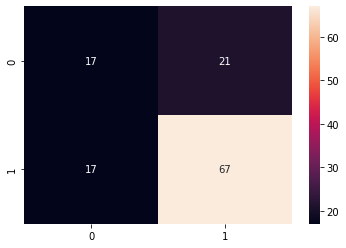

In [65]:
sns.heatmap(cm_adaboost, annot=True, fmt="d")

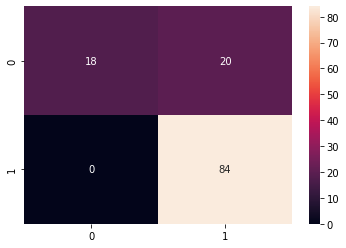

In [66]:
sns.heatmap(cm_tunned_adaboost, annot=True, fmt="d")

#### Overall Accuracy

In [67]:
print(f'Accuracy Score of AdaBoost Clasifier is {accuracy_score_adaboost}')
final_evaluation["accuracy_score"].append(accuracy_score_adaboost) 
print(f'Accuracy Score of Tuned ADA Boost  is {accuracy_ada_tuned}')
final_evaluation['accuracy_score'].append(accuracy_ada_tuned)

Accuracy Score of AdaBoost Clasifier is 0.7068106090896975
Accuracy Score of Tuned ADA Boost  is 0.809489537518326


#### F1-Score

In [68]:
print(f"F1 score of AdaBoost Clasifier : {f1_score_adaboost}")
final_evaluation["F1 score"].append(f1_score_adaboost) 

F1 score of AdaBoost Clasifier : 0.7920979247658724


In [69]:
print(f'F1-Score of Tuned AdaBoost Clasifier is {f1_score_tunned_adaboost}')
final_evaluation["F1 score"].append(f1_score_tunned_adaboost) 

F1-Score of Tuned AdaBoost Clasifier is 0.8766589292019982


#### ROC curve and AUC

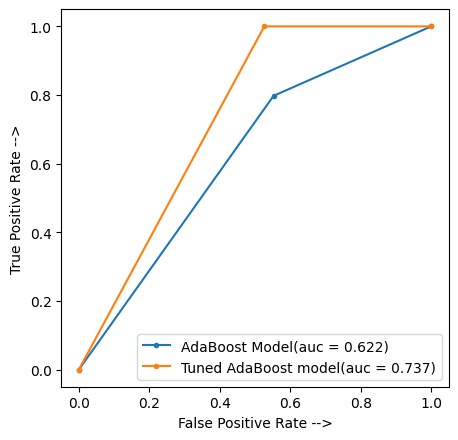

In [70]:
ada_fpr, ada_tpr, threshold = roc
auc_ada = auc(ada_fpr, ada_tpr)

tuned_ada_fpr, tuned_ada_tpr, threshold = roc_tuned
tuned_auc_ada = auc(tuned_ada_fpr, tuned_ada_tpr)

plt.figure(figsize=(5, 5), dpi=100)
plt.plot(ada_fpr, ada_tpr, linestyle='-', marker='.', label='AdaBoost Model(auc = %0.3f)' % auc_ada)
plt.plot(tuned_ada_fpr, tuned_ada_tpr, marker='.', label='Tuned AdaBoost model(auc = %0.3f)' % tuned_auc_ada)
final_evaluation["auc"].append(auc_ada) 
final_evaluation["auc"].append(tuned_auc_ada) 

plt.xlabel('False Positive Rate -->')
plt.ylabel('True Positive Rate -->')

plt.legend()

plt.show()

#### Learning Curve

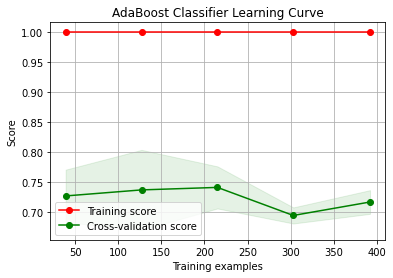

In [71]:
import scikitplot as skplt
skplt.estimators.plot_learning_curve(adaBoost_clf, X_train, y_train, title="AdaBoost Classifier Learning Curve",
                                     scoring = 'accuracy', cv=skf, random_state=_random_state)
plt.show()

## Gradient Boosting Classifier

### Training Gradient Boosting Classifier Classifier

In [72]:
gb_clf = GradientBoostingClassifier(random_state =_random_state)
gb_clf.fit(X_train, y_train)


GradientBoostingClassifier(random_state=4)

In [73]:
y_pred_gboost= gb_clf.predict(X_test)
accuracy_gb_clf = accuracy_score(y_test, y_pred_gboost)
print(f'Accuracy Score of Gradient Boosting classifier model is {accuracy_score(y_test, y_pred_gboost)}')
final_evaluation["Model"].append("GradientBoostingClassifier")  

Accuracy Score of Gradient Boosting classifier model is 0.7967479674796748


### Tuning Gradient Boosting Classifier Classifier

In [74]:
n_estimators = [10, 100, 1000]
learning_rate = [0.001, 0.01, 0.1]
subsample = [0.5, 0.7, 1.0]
max_depth = [3, 7, 9]


model = GradientBoostingClassifier(random_state =_random_state)
grid = dict(learning_rate = learning_rate, n_estimators = n_estimators, subsample = subsample, max_depth = max_depth)
grid_search = GridSearchCV(estimator=model, param_grid=grid, n_jobs=-1, scoring='accuracy',error_score=0)
grid_result = grid_search.fit(X_train, y_train)
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))


Best: 0.800371 using {'learning_rate': 0.001, 'max_depth': 3, 'n_estimators': 1000, 'subsample': 0.5}


In [75]:
# Tuning with stratified fold on one test set 

gb_clf_tuned = GradientBoostingClassifier(random_state =_random_state, n_estimators=1000,learning_rate=0.001,subsample=0.5,max_depth=3)
gb_clf_tuned.fit(X_train, y_train)
y_pred_tuned_gboost = gb_clf_tuned.predict(X_test)

#Calculating accuracy score between test value and predictive value for target
accuracy_gb_clf_tuned = accuracy_score(y_test, y_pred_tuned_gboost)

#Caculating Ensemble Score for Model
print(f'Accuracy Score of Tuned Gradient Boosting Classifier is {accuracy_gb_clf_tuned}')
final_evaluation["Model"].append("Tuned GradientBoostingClassifier") 

Accuracy Score of Tuned Gradient Boosting Classifier is 0.8292682926829268


### Stratefied K Fold Validation For Gradient Boosting Classifier Classifier

In [76]:
accuracy_gboost = []
accuracy_tuned_gboost = []
cm_gboost = []
cm_tunned_gboost = []
f1_score_gboost = []
f1_score_tunned_gboost = []
roc = []
roc_tuned = []

skf = StratifiedKFold(n_splits = 5,random_state = _random_state, shuffle = True)

skf.get_n_splits(X,y)
for train_index, test_index in skf.split(X,y):
  X1_train, X1_test = X[train_index],X[test_index]
  y1_train, y1_test = y[train_index],y[test_index]
  # classifier.fit(X1_train,y1_train)
  
  gb_clf.fit(X1_train,y1_train)
  gboost_predictions = gb_clf.predict(X1_test)
  score = accuracy_score(gboost_predictions,y1_test)
  accuracy_gboost.append(score)
  cm_gboost = confusion_matrix(y1_test, gboost_predictions)
  f1 = f1_score(y1_test, gboost_predictions)
  f1_score_gboost.append(f1)
  roc = roc_curve(y1_test, gboost_predictions)

  gb_clf_tuned.fit(X1_train,y1_train)
  tuned_gboost_predictions = gb_clf_tuned.predict(X1_test)
  score = accuracy_score(tuned_gboost_predictions,y1_test)
  accuracy_tuned_gboost.append(score)
  cm_tunned_gboost = confusion_matrix(y1_test, tuned_gboost_predictions)
  f1 = f1_score(y1_test, tuned_gboost_predictions)
  f1_score_tunned_gboost.append(f1)
  roc_tuned = roc_curve(y1_test, tuned_gboost_predictions)

accuracy_gb_clf = np.array(accuracy_gboost).mean()
accuracy_gb_clf_tuned = np.array(accuracy_tuned_gboost).mean()
f1_score_gboost = np.array(f1_score_gboost).mean()
f1_score_tunned_gboost = np.array(f1_score_tunned_gboost).mean()

print(f'Accuracy Score of Gradient Boosting Classifier is {accuracy_gb_clf}')
print(f'Accuracy Score of Tuned Gradient Boosting Classifier is {accuracy_gb_clf_tuned}')

Accuracy Score of Gradient Boosting Classifier is 0.7834466213514595
Accuracy Score of Tuned Gradient Boosting Classifier is 0.8062375049980008


### Evaluation

#### Confusion Matrix

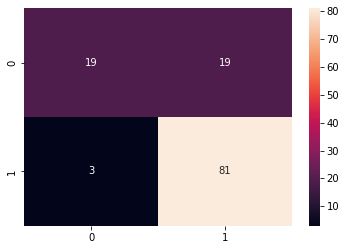

In [77]:
sns.heatmap(cm_gboost, annot=True, fmt="d")

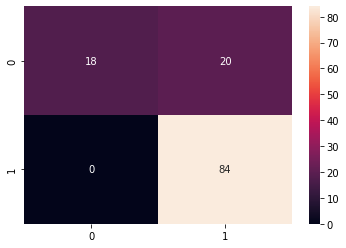

In [78]:
sns.heatmap(cm_tunned_gboost, annot=True, fmt="d")

#### Overall Accuracy

In [79]:
print(f'Accuracy Score of Gradient Boosting Classifier is {accuracy_gb_clf}')
final_evaluation['accuracy_score'].append(accuracy_gb_clf)
print(f'Accuracy Score of Tuned Gradient Boosting Classifier is {accuracy_gb_clf_tuned}')
final_evaluation['accuracy_score'].append(accuracy_gb_clf_tuned)

Accuracy Score of Gradient Boosting Classifier is 0.7834466213514595
Accuracy Score of Tuned Gradient Boosting Classifier is 0.8062375049980008


#### F1-Score

In [80]:
print(f'F1-Score of Gradient Boosting Classifier is {f1_score_gboost}')
final_evaluation["F1 score"].append(f1_score_gboost)

F1-Score of Gradient Boosting Classifier is 0.8547121264182562


In [81]:
print(f'F1-Score of Tuned Gradient Boosting Classifier is {f1_score_tunned_gboost}')
final_evaluation["F1 score"].append(f1_score_tunned_gboost)

F1-Score of Tuned Gradient Boosting Classifier is 0.8749104845983732


#### ROC curve and AUC

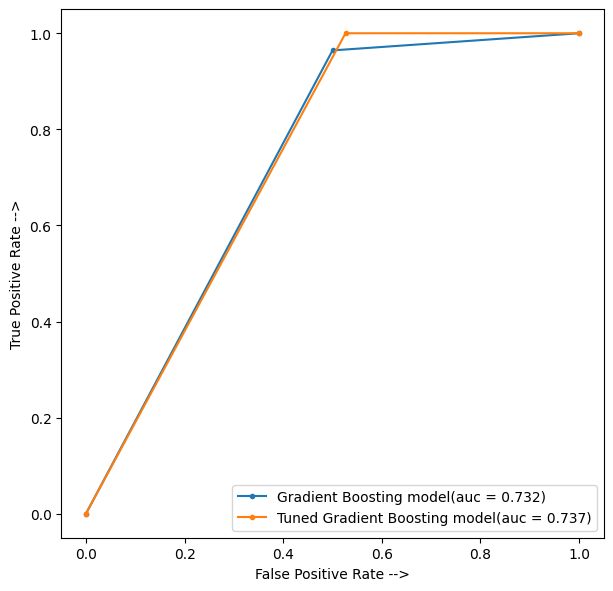

In [82]:
gboost_fpr, gboost_tpr, threshold = roc
auc_gboost = auc(gboost_fpr, gboost_tpr)

tuned_gboost_fpr, tuned_gboost_tpr, threshold = roc_tuned
tuned_auc_gboost = auc(tuned_gboost_fpr, tuned_gboost_tpr)

plt.figure(figsize=(7, 7), dpi=100)
plt.plot(gboost_fpr, gboost_tpr, linestyle='-', marker='.', label='Gradient Boosting model(auc = %0.3f)' % auc_gboost)
plt.plot(tuned_gboost_fpr, tuned_gboost_tpr, marker='.', label='Tuned Gradient Boosting model(auc = %0.3f)' % tuned_auc_gboost)
final_evaluation["auc"].append(auc_gboost) 
final_evaluation["auc"].append(tuned_auc_gboost) 

plt.xlabel('False Positive Rate -->')
plt.ylabel('True Positive Rate -->')

plt.legend()

plt.show()

#### Learning Curve

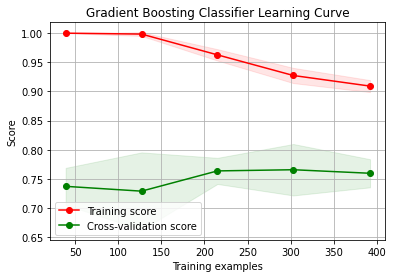

In [83]:
import scikitplot as skplt
skplt.estimators.plot_learning_curve(gb_clf, X_train, y_train, title="Gradient Boosting Classifier Learning Curve",
                                     scoring = 'accuracy', cv=skf, random_state=_random_state)
plt.show()

# Model Comparison

##ROC Curve Comparison

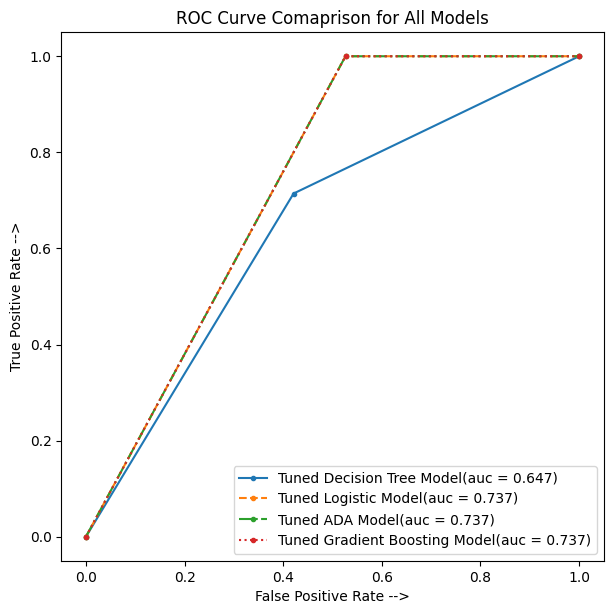

In [84]:

plt.figure(figsize=(7, 7), dpi=100)

plt.plot(tuned_decision_tree_fpr, tuned_decision_tree_tpr, linestyle ='-' , 
         marker='.', label='Tuned Decision Tree Model(auc = %0.3f)' % tuned_auc_decision_tree)

plt.plot(tuned_logistic_fpr, tuned_logistic_tpr, linestyle ='--' , marker='.',
         label='Tuned Logistic Model(auc = %0.3f)' % tuned_auc_logistic)

plt.plot(tuned_ada_fpr, tuned_ada_tpr, linestyle ='-.' , marker='.', 
         label='Tuned ADA Model(auc = %0.3f)' % tuned_auc_ada)

plt.plot(tuned_gboost_fpr, tuned_gboost_tpr,linestyle =':', marker='.', 
         label='Tuned Gradient Boosting Model(auc = %0.3f)' % tuned_auc_gboost)

plt.title('ROC Curve Comaprison for All Models')
plt.xlabel('False Positive Rate -->')
plt.ylabel('True Positive Rate -->')

plt.legend()

plt.show()

As per ROC and AUC curves we can see that the AUC value for 3 models - logistic model, ada boost, and gradient boosting have same AUC as 0.737

In [85]:
final_eval = pd.DataFrame(final_evaluation)
final_eval

,Model,accuracy_score,auc,F1 score
0,DecisionTreeClassifier,0.693802,0.665727,0.774979
1,Tuned DecisionTreeClassifier,0.724670,0.646617,0.798954
2,LogisticRegression,0.796481,0.736842,0.866395
3,Tuned LogisticRegression,0.811116,0.736842,0.877308
4,AdaBoostClassifier,0.706811,0.622494,0.792098
5,Tuned AdaBoost,0.809490,0.736842,0.876659
6,GradientBoostingClassifier,0.783447,0.732143,0.854712
7,Tuned GradientBoostingClassifier,0.806238,0.736842,0.874910


# Conclusion

As per the evaluation of all the models: Decision Tree Classifier, Logistic Regression, AdaBoost Classifier using metrics such as Accuracy Score, F1-Score, Confusion Matrix, Learning Curves, ROC, and AUC we can see that Logistic Regression Model performed the best among all the models, followed by AdaBoost classifier, GradientBoosting classifier and finally Decision Tree classifier.